In [1]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torch
from PIL import Image

/home/crack/miniconda3/envs/road_anomaly_detector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/crack/miniconda3/envs/road_anomaly_detector/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/crack/miniconda3/envs/road_anomaly_detector/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/crack/miniconda3/envs/road_anomaly_detector/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision

Load and normalize `example_image.jpg`. You can also load through an URL.

In [2]:
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")

Predict and visualize (this might take a few seconds if running without GPU support)

In [65]:
import torch
from PIL import Image

# Define a new input size
new_input_size = (512, 512)

# Load and process the image
image = Image.open("test_images/test3.png").convert("RGB")
image_inputs = processor.image_processor(images=image, return_tensors="pt", size=new_input_size)

# Process the text prompts
prompts = ['thin road cracks']

# Repeat the image for each prompt
batch_size = len(prompts)
pixel_values = image_inputs["pixel_values"].repeat(batch_size, 1, 1, 1)

text_inputs = processor.tokenizer(
    text=prompts,
    return_tensors="pt",
    padding=True,
    truncation=True
)

# Transfer model and inputs to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Transfer model to GPU
pixel_values = pixel_values.to(device)
input_ids = text_inputs["input_ids"].to(device)
attention_mask = text_inputs["attention_mask"].to(device)

# Combine the processed inputs
inputs = {
    "pixel_values": pixel_values,
    "input_ids": input_ids,
    "attention_mask": attention_mask
}

# Forward pass on GPU
outputs = model(**inputs, interpolate_pos_encoding=True)


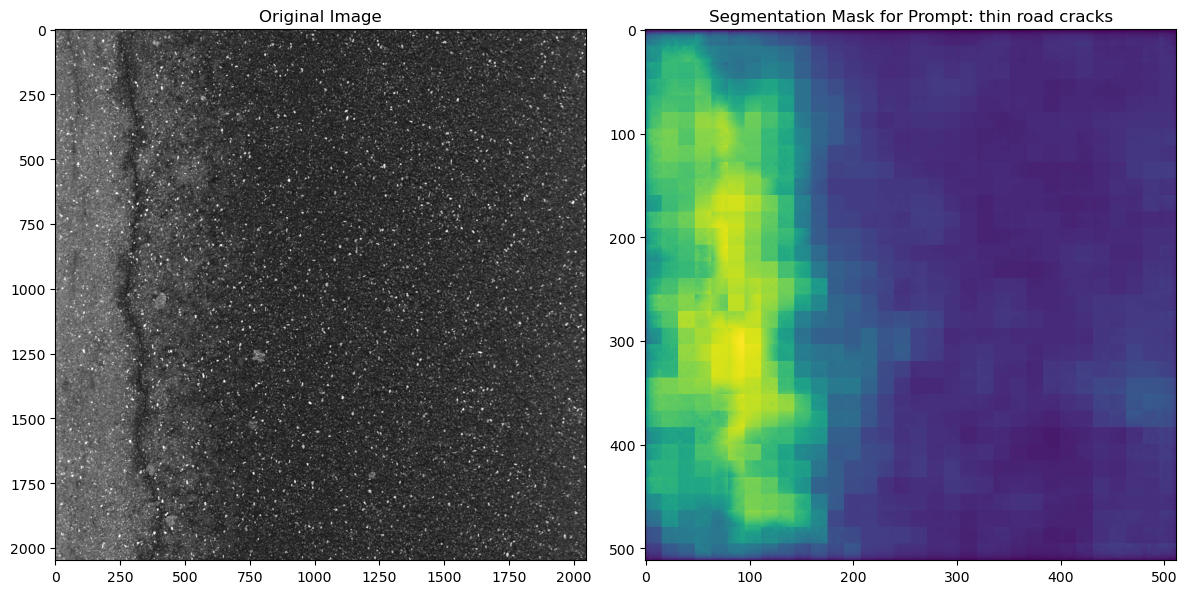

In [66]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Assuming 'outputs' is the result from the model
# Extract the segmentation mask
segmentation_masks = outputs.logits  # Shape: (batch_size, height, width)

# Choose a prompt index to visualize
index_to_visualize = 0  # Change this to visualize other prompts
segmentation_mask = segmentation_masks[index_to_visualize]

# Normalize and convert to an image
segmentation_mask = segmentation_mask.sigmoid()  # Apply sigmoid to get probabilities
segmentation_image = to_pil_image(segmentation_mask)

# Use the original image (before preprocessing) for RGB visualization
# Ensure you pass the original image
original_image = image  # Assuming `image` is the PIL.Image object before processing

# Display the original image and segmentation mask side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[0].axis("on")  # Enable x and y axes

# Display the segmentation mask
ax[1].imshow(segmentation_image, cmap="viridis")  # Use a color map for better visualization
ax[1].set_title(f"Segmentation Mask for Prompt: {prompts[index_to_visualize]}")
ax[1].axis("on")  # Enable x and y axes

plt.tight_layout()
plt.show()
